# Projeto Órama Discovery
## Grupo 10 – Daniel N. Rocha, Mateus, Letícia Fiorito, Wallys
Este projeto visa ajudar na melhor alocação de recomendações de produtos da Órama em contextos de informação assimétrica, como em plublicidade em sites. <br>
<br>
- Dado que é um fato que **diversos clientes não preenchem o questionário de suitability** (cuja função é classificar o perfil de investimento do usuário), muitas das vezes é **difícil realizar uma remomendação de produtos** de forma eficiente. <br>
<br>
- Neste trabalho, usamos **algoritmos de Machine Learning** para estimar o perfil dos usuário **somente com informações demográficas** (idade, sexo, renda, etc.), que todos os usuário já respondem obrigatoriamente ao se inscreverem na plataforma. <br>
<br>
- Após testar diversos algoritmos, conseguimos obter <font color='red'>**aproximadamente 70% de acurácia preditiva no nosso modelo final**</font>, utilizando o algoritmo Support Vector Machine. <br>
<br>
- Além da possibilidade de ser usar dentro do aplicativo e do site da Órama, este algoritmo também permite **melhores recomendações com publicidade em sites de terceiros**, desde que haja alguma informação sobre o perfil demográfico do público-alvo que frequenta estes outros sites. <br>
<br>
- Acreditamos que essa tecnologia consegue dar significativa **vantagem competitiva** à Órama, tendo em vista a possibilidade de realizar **recomendações de forma mais personalizada** e precisa (mesmo em cenários de informação assimétrica).<br>
<br>

Nota: todos os dados foram disponibilizados pela própria Órama, e são dados reais sobre os produtos e clientes da Órama. Todos os dados sensíveis foram anonimizados de modo a não incorrer em nenhuma violação de privacidade.

### Importando pacotes e fazendos ajustes:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color','axes.titlesize',
    'figure.figsize','legend.framealpha'],['white','white','white','white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

### Importando os dados e calculando a idade a partir da data de nascimento:

In [1565]:
clients = pd.read_json('/Users/pedrocerbino/Downloads/clientes (1).json')
clients['age'] = [2020-int(i[:4]) for i in clients.birth_date]
# Eliminamos informações que não nos são de interesse
clients.drop(inplace=True,columns=['email','cpf_cnpj','birth_location','birth_date','answers'])
clients.head(2)

,full_name,investor_profile,is_qualified_investor,has_investor_profile,state,net_asset,mensal_earnings,gender,civil_status,age
0,Nome215,Arrojado,False,True,Rio de Janeiro,"Acima de R$1.000.000,00","Até R$5.000,00",Masculino,Casado(a),76
1,Nome216,Moderado,False,True,Rio de Janeiro,"De R$200.000,01 a R$300.000,00","Até R$5.000,00",Masculino,Casado(a),71


### Transformando variável contínua (idade) em categórica (faixas de idade):

In [1567]:
clients.age = ['Young' if i <= 35.5 else 'Adult' if i > 35.5 and i <= 50.0 else 'MidAge' 
        if i > 50.0 and i <= 64.5 else 'Old' if i > 64.5 else 'None' for i in clients.age]

### Filtrando somente para os clientes que responderam o Suitability
Suitability é o questionário que visa mapear o perfil do investidos (mais sucetível a tomar risco ou não). As categorias definidas pela Órama são Conservador, Moderado e Arrojado.

In [1581]:
clients_profile = clients[clients.has_investor_profile == True].copy()
clients_profile.reset_index(inplace=True, drop=True)

### Corrigindo um erro dos dados
Como verificado abaixo, as observações _1830_, _1832_ e _3550_ são de cliente sem suitability. Contudo, a tabela aponta como se tivessem respondido ao questionário. Para evitar problemas, removemos essas observações dos dados).

In [1583]:
c=0
for i in clients_profile.answers:
    try:
        k = i[-1]
    except:
        print(c)
    c+=1

In [1584]:
clients_profile.drop(index=[1830,1832,3550],inplace=True)
clients_profile.tail(2)

,full_name,investor_profile,is_qualified_investor,has_investor_profile,state,net_asset,mensal_earnings,gender,civil_status,age
5347,Nome73281,Moderado,False,True,Minas Gerais,"Até R$50.000,00","De R$10.000,01 a R$20.000,00",Masculino,Solteiro(a),Young
5348,Nome73287,Moderado,False,True,Santa Catarina,"Até R$50.000,00","Até R$5.000,00",Feminino,União estável,Old


### Analisando o perfil dos dados de cada perfil de investimento:
Vamos fazer uma análise dos dados demográficos para verificar se de fato existe diferença entre as características médias dos perfis mapeados pelo Suitability. O resultado mostra que há diferenças significativas, de modo que faz sentido utilizar um algoritmo de classificação em cima dessas informações.

In [1308]:
def profile_frequencies(profile='clients_profile'):
    """
    Return the frequency for each selected indicator
    Profile: 'Moderado', 'Arrojado', 'Conservador'
    """
    if profile == 'clients_profile':
        df = clients_profile
    else:
        df = clients_profile[clients_profile.investor_profile == profile]
    for i in ['investor_profile','state','gender','civil_status','net_asset','mensal_earnings']:
        print(df[i].value_counts(normalize=True).round(decimals=3)*100,'\n')
    print(pd.Series(df.age).value_counts(normalize=True,bins=4,sort=False).round(decimals=3)*100)

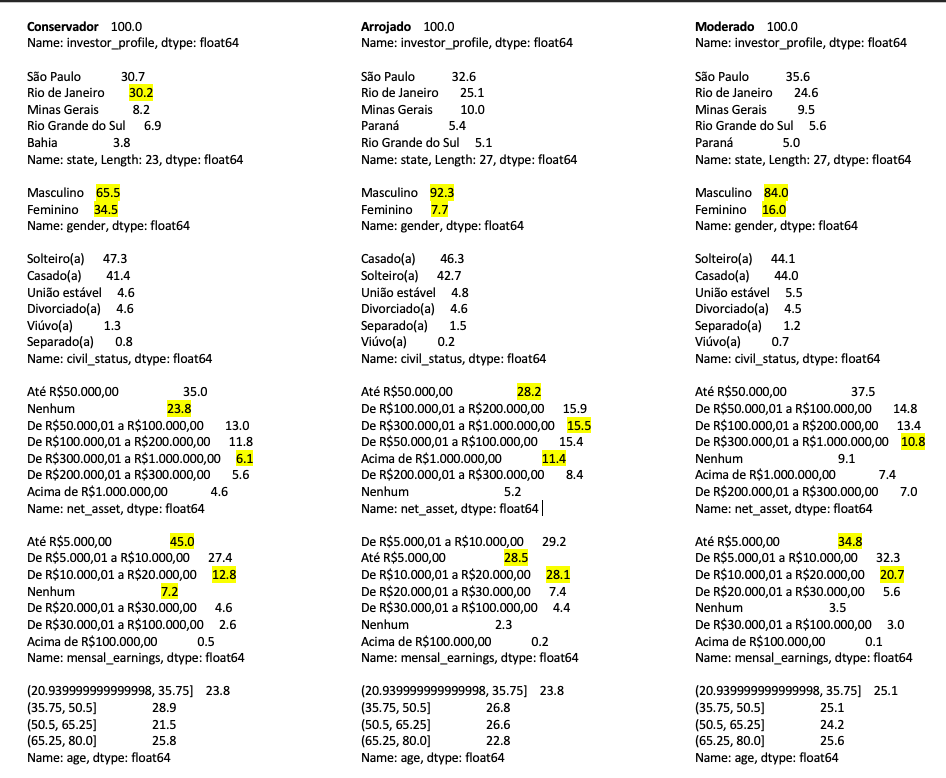

### Plotando algumas variáveis de interesse:

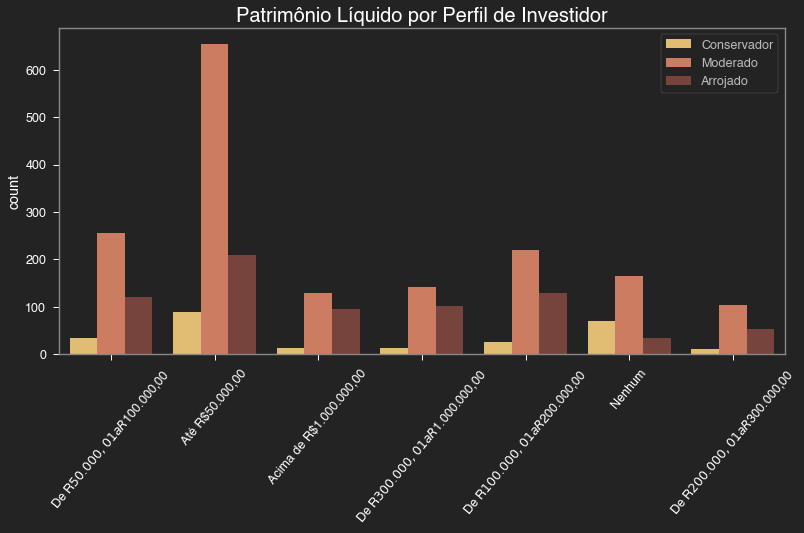

In [1393]:
plt.figure(figsize=(13,6))
plt.title('Patrimônio Líquido por Perfil de Investidor')
cmap = palettable.scientific.sequential.LaJolla_5.hex_colors[1:4]
sns.countplot('net_asset', data=clients_filtered, hue='investor_profile', palette=cmap)
plt.legend(['Conservador','Moderado','Arrojado'])
plt.xticks(rotation=50)
plt.xlabel('');

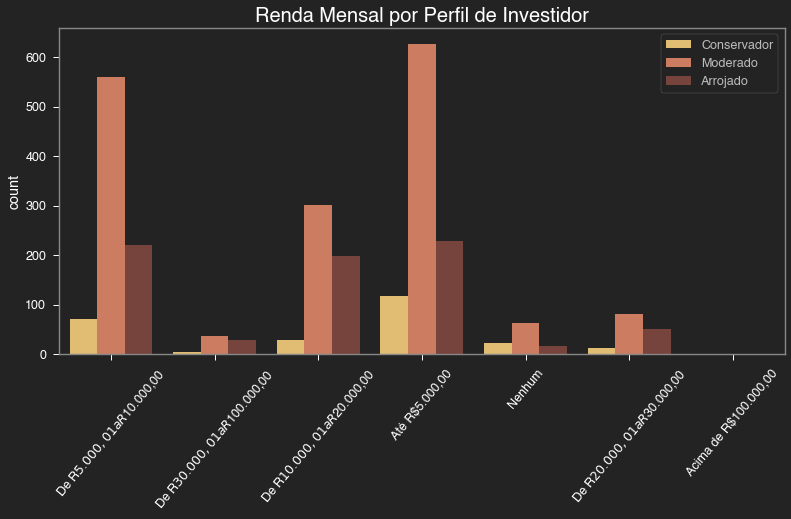

In [1397]:
plt.figure(figsize=(13,6))
plt.title('Renda Mensal por Perfil de Investidor')
sns.countplot('mensal_earnings', data=clients_filtered, hue='investor_profile', palette=cmap)
plt.legend(['Conservador','Moderado','Arrojado'])
plt.xticks(rotation=50)
plt.xlabel('');

### Tranformando as variáveis categóricas em dummies:
O parâmetro _drop_first_ elimina a primeira categoria encontrada, de modo a evitar multicolinearidade no modelo (ou seja, evitar colunas que sejam linearmente dependentes)

In [1625]:
dummy_df = pd.get_dummies(clients,drop_first=True,columns=['is_qualified_investor', 'state',
        'has_investor_profile', 'net_asset', 'mensal_earnings', 'gender', 'civil_status', 'age'])
dummy_df.investor_profile=dummy_df.investor_profile.map({'Conservador':0,'Moderado':1,'Arrojado':2})
dummy_df.dropna(inplace=True)
dummy_df.head(2)

,full_name,investor_profile,is_qualified_investor_True,state_Alagoas,state_Amapá,state_Amazonas,state_Bahia,state_Ceará,state_Distrito Federal,state_Espírito Santo,state_Goiás,state_Maranhão,state_Mato Grosso,state_Mato Grosso do Sul,state_Minas Gerais,state_Paraná,state_Paraíba,state_Pará,state_Pernambuco,state_Piauí,state_Rio Grande do Norte,state_Rio Grande do Sul,state_Rio de Janeiro,state_Rondônia,state_Roraima,state_Santa Catarina,state_Sergipe,state_São Paulo,state_Tocantins,has_investor_profile_True,"net_asset_Até R$50.000,00","net_asset_De R$100.000,01 a R$200.000,00","net_asset_De R$200.000,01 a R$300.000,00","net_asset_De R$300.000,01 a R$1.000.000,00","net_asset_De R$50.000,01 a R$100.000,00",net_asset_Nenhum,"mensal_earnings_Até R$5.000,00","mensal_earnings_De R$10.000,01 a R$20.000,00","mensal_earnings_De R$20.000,01 a R$30.000,00","mensal_earnings_De R$30.000,01 a R$100.000,00","mensal_earnings_De R$5.000,01 a R$10.000,00",mensal_earnings_Nenhum,gender_Masculino,civil_status_Divorciado(a),civil_status_Separado(a),civil_status_Solteiro(a),civil_status_União estável,civil_status_Viúvo(a),age_MidAge,age_Old,age_Young
0,Nome215,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Nome216,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


### Separando a variável de interesse das variáveis explicativas:

In [1626]:
X = dummy_df.drop(columns=['full_name','investor_profile'])
y = dummy_df['investor_profile']

In [1627]:
print('A quantidade de colunas nulas é: ', dummy_df.isnull().any().sum())

A quantidade de colunas nulas é:  0


### Separando os dados entre amostra de treinamento e de teste:

In [1628]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

### Ajustando os dados para a mesma escala, de modo a evitar distorções:

In [1629]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Random Forest

In [1645]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [1646]:
rfc_pred = rfc.predict(X_test)

### Avaliando o Modelo
Plotamos a matriz de confusão para avaliar a capacidade preditiva do modelo. Os valores dentro da matriz representam probabilidades.

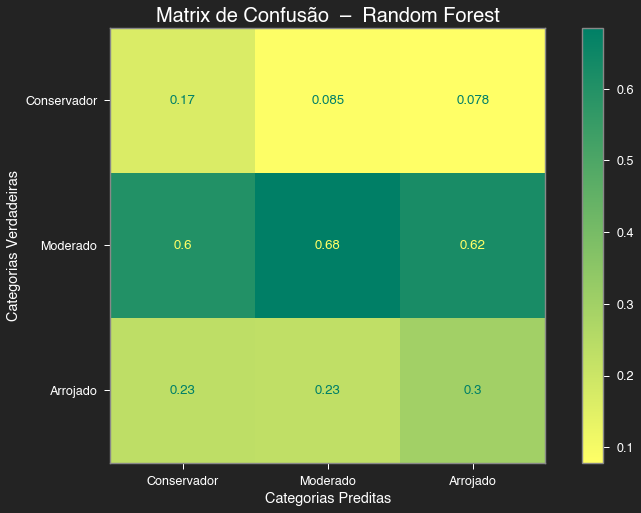

In [1647]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                                 display_labels=['Conservador','Moderado','Arrojado'],
                                 cmap=plt.cm.summer_r,
                                 normalize='pred')
disp.ax_.set_title('Matrix de Confusão  –  Random Forest')
disp.ax_.set_ylabel('Categorias Verdadeiras')
disp.ax_.set_xlabel('Categorias Preditas');

In [1648]:
print(classification_report(y_test,rfc_pred))
print('Recall Score: {:.2f} %'.format(recall_score(y_test, rfc_pred,average='weighted')*100))
print('Accuracy Score: {:.2f} %'.format(accuracy_score(y_test, rfc_pred)*100))

              precision    recall  f1-score   support

         0.0       0.17      0.04      0.06       138
         1.0       0.68      0.86      0.76      1083
         2.0       0.30      0.17      0.22       384

    accuracy                           0.62      1605
   macro avg       0.38      0.35      0.35      1605
weighted avg       0.55      0.62      0.57      1605

Recall Score: 62.31 %
Accuracy Score: 62.31 %


In [1815]:
accuracies = cross_validate(estimator=rfc, X=X_train, y=y_train, cv=10, scoring='f1_micro')
print("Accuracy: {:.2f} %".format(accuracies['test_score'].mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies['test_score'].std()*100))

Accuracy: 63.92 %
Standard Deviation: 1.50 %


## XGBoost

In [1713]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1714]:
xgboost_pred = xgboost.predict(X_test)

### Avaliando o Modelo
Plotamos a matriz de confusão para avaliar a capacidade preditiva do modelo. Os valores dentro da matriz representam probabilidades.

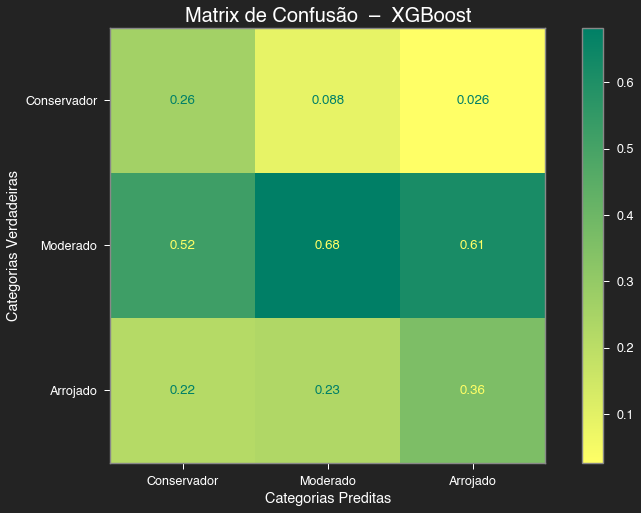

In [1715]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(xgboost, X_test, y_test,
                                 display_labels=['Conservador','Moderado','Arrojado'],
                                 cmap=plt.cm.summer_r,
                                 normalize='pred')
disp.ax_.set_title('Matrix de Confusão  –  XGBoost')
disp.ax_.set_ylabel('Categorias Verdadeiras')
disp.ax_.set_xlabel('Categorias Preditas');

In [1716]:
print(classification_report(y_test,xgboost_pred))
print('Recall Score: {:.2f} %'.format(recall_score(y_test, xgboost_pred,average='weighted')*100))
print('Accuracy Score: {:.2f} %'.format(accuracy_score(y_test, xgboost_pred)*100))

              precision    recall  f1-score   support

         0.0       0.26      0.04      0.07       138
         1.0       0.68      0.92      0.78      1083
         2.0       0.36      0.11      0.16       384

    accuracy                           0.65      1605
   macro avg       0.43      0.36      0.34      1605
weighted avg       0.57      0.65      0.58      1605

Recall Score: 65.30 %
Accuracy Score: 65.30 %


In [1814]:
accuracies = cross_validate(estimator=xgboost, X=X_train, y=y_train, cv=10, scoring='f1_micro')
print("Accuracy: {:.2f} %".format(accuracies['test_score'].mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies['test_score'].std()*100))

Accuracy: 66.93 %
Standard Deviation: 1.42 %


## Logistic Regression

In [1655]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state = 0)
logistic.fit(X_train, y_train)## Kernel Support Vector Machine

LogisticRegression(random_state=0)

In [1656]:
logistic_pred = logistic.predict(X_test)

### Avaliando o Modelo
Plotamos a matriz de confusão para avaliar a capacidade preditiva do modelo. Os valores dentro da matriz representam probabilidades.

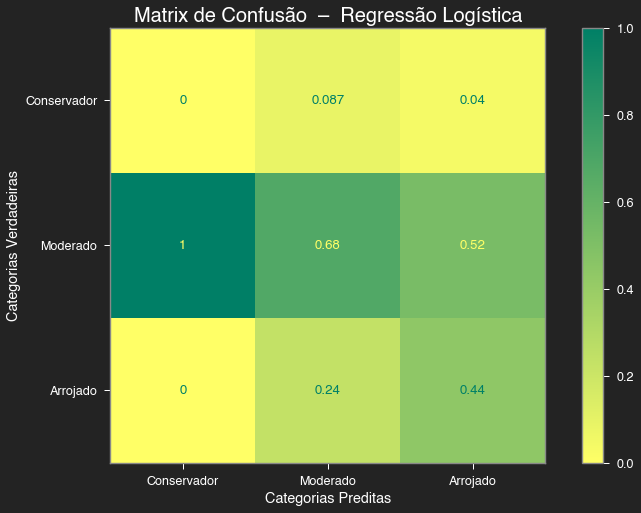

In [1657]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(logistic, X_test, y_test,
                                 display_labels=['Conservador','Moderado','Arrojado'],
                                 cmap=plt.cm.summer_r,
                                 normalize='pred')
disp.ax_.set_title('Matrix de Confusão  –  Regressão Logística')
disp.ax_.set_ylabel('Categorias Verdadeiras')
disp.ax_.set_xlabel('Categorias Preditas');

In [1658]:
print(classification_report(y_test,logistic_pred))
print('Recall Score: {:.2f} %'.format(recall_score(y_test, logistic_pred,average='weighted')*100))
print('Accuracy Score: {:.2f} %'.format(accuracy_score(y_test, logistic_pred)*100))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       138
         1.0       0.68      0.99      0.80      1083
         2.0       0.44      0.03      0.05       384

    accuracy                           0.67      1605
   macro avg       0.37      0.34      0.29      1605
weighted avg       0.56      0.67      0.55      1605

Recall Score: 67.29 %
Accuracy Score: 67.29 %


In [1813]:
from sklearn.model_selection import cross_validate
accuracies = cross_validate(estimator=logistic, X=X_train, y=y_train, cv=10, scoring='f1_micro')
print("Accuracy: {:.2f} %".format(accuracies['test_score'].mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies['test_score'].std()*100))

Accuracy: 69.60 %
Standard Deviation: 0.35 %


## Kernel Support Vector Machine

In [1640]:
from sklearn.svm import SVC
kernelsvm = SVC(kernel = 'rbf', random_state = 0)
kernelsvm.fit(X_train, y_train)

SVC(random_state=0)

In [1641]:
kernelsvm_pred = kernelsvm.predict(X_test)

### Avaliando o Modelo
Plotamos a matriz de confusão para avaliar a capacidade preditiva do modelo. Os valores dentro da matriz representam probabilidades.

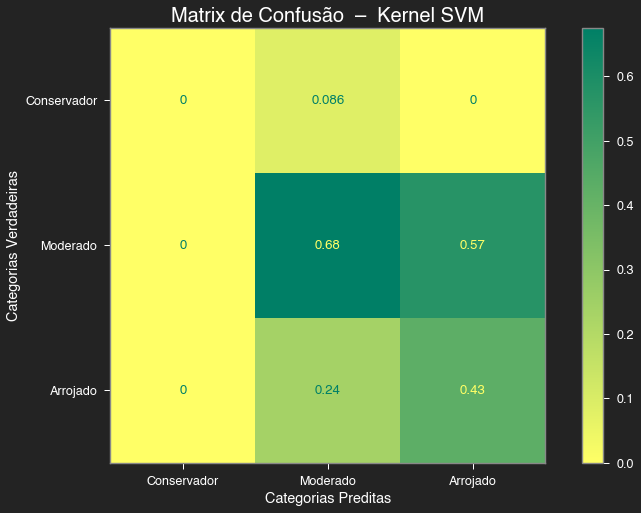

In [1642]:
disp = plot_confusion_matrix(kernelsvm, X_test, y_test,
                                 display_labels=['Conservador','Moderado','Arrojado'],
                                 cmap=plt.cm.summer_r,
                                 normalize='pred')
disp.ax_.set_title('Matrix de Confusão  –  Kernel SVM')
disp.ax_.set_ylabel('Categorias Verdadeiras')
disp.ax_.set_xlabel('Categorias Preditas');

In [1643]:
print(classification_report(y_test,kernelsvm_pred))
print('Recall Score: {:.2f} %'.format(recall_score(y_test, kernelsvm_pred,average='weighted')*100))
print('Accuracy Score: {:.2f} %'.format(accuracy_score(y_test, kernelsvm_pred)*100))

/Users/pedrocerbino/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       138
         1.0       0.68      1.00      0.80      1083
         2.0       0.43      0.01      0.02       384

    accuracy                           0.67      1605
   macro avg       0.37      0.33      0.27      1605
weighted avg       0.56      0.67      0.55      1605

Recall Score: 67.41 %
Accuracy Score: 67.41 %


In [1816]:
accuracies = cross_validate(estimator=kernelsvm,X=X_train,y=y_train,cv=10,scoring='f1_micro')
print("Accuracy: {:.2f} %".format(accuracies['test_score'].mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies['test_score'].std()*100))

Accuracy: 69.69 %
Standard Deviation: 0.27 %


## Support Vector Machine

In [1660]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', random_state = 0)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [1661]:
svm_pred = svm.predict(X_test)

### Avaliando o Modelo
Plotamos a matriz de confusão para avaliar a capacidade preditiva do modelo. Os valores dentro da matriz representam probabilidades.

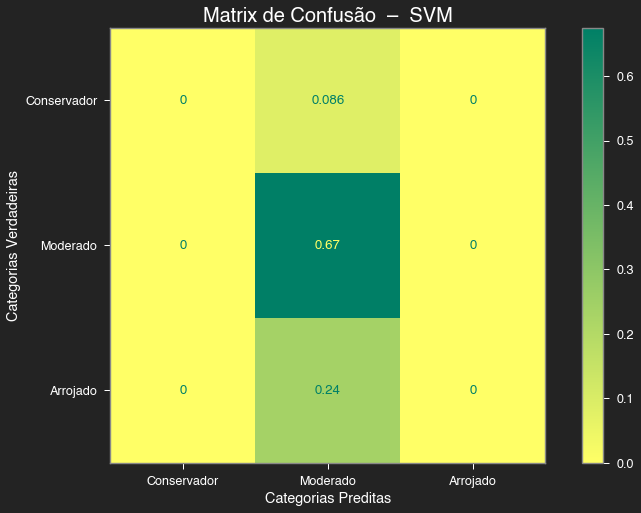

In [1662]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(svm, X_test, y_test,
                                 display_labels=['Conservador','Moderado','Arrojado'],
                                 cmap=plt.cm.summer_r,
                                 normalize='pred')
disp.ax_.set_title('Matrix de Confusão  –  SVM')
disp.ax_.set_ylabel('Categorias Verdadeiras')
disp.ax_.set_xlabel('Categorias Preditas');

In [1809]:
print(classification_report(y_test,svm_pred))
print('Recall Score: {:.2f} %'.format(recall_score(y_test, svm_pred,average='weighted')*100))
print('Accuracy Score: {:.2f} %'.format(accuracy_score(y_test, svm_pred)*100))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       138
         1.0       0.67      1.00      0.81      1083
         2.0       0.00      0.00      0.00       384

    accuracy                           0.67      1605
   macro avg       0.22      0.33      0.27      1605
weighted avg       0.46      0.67      0.54      1605

Recall Score: 67.48 %
Accuracy Score: 67.48 %


In [1812]:
accuracies = cross_validate(estimator=svm, X=X_train, y=y_train, cv=10, scoring='f1_micro')
print("Accuracy: {:.2f} %".format(accuracies['test_score'].mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies['test_score'].std()*100))

Accuracy: 69.71 %
Standard Deviation: 0.25 %


### Procuramos os melhores hyperparâmetros (RF + Optuna):
Para esta tarefa, utilizamos o Optuna, que é uma ferramenta de busca que permite paralelização, fazendo com que o processo de testagem dos parâmatros fique otimizado. Optamos por testar otimizar o algoritmo de Random Forest pois ele naturalmente já evita overfitting (diferentemente de uma Decision Tree, por exemplo) e devido ao fato dele ter desempenhado relativamente melhor que outros algoritmos nos nossos testes.

In [1736]:
# Importing the Packages:
import optuna
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
from sklearn import model_selection
from sklearn import ensemble

import warnings
warnings.filterwarnings("ignore")

# Importing Data
X = dummy_df.drop(columns=['full_name','investor_profile'])
y = dummy_df['investor_profile']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 0)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Step 1. Define an objective function to be maximized.
def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = linear_model.LogisticRegression(C=logreg_c)
    else:
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators
        )

    for step in range(100):
        classifier_obj.fit(X_train, y_train)
        
        # Report intermediate objective value.
        intermediate_value = classifier_obj.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return intermediate_value

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

[I 2020-11-15 17:30:30,848] Trial 0 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 414, 'rf_max_depth': 2}. Best is trial 0 with value: 0.6747663551401869.
[I 2020-11-15 17:30:31,103] Trial 1 finished with value: 0.6735202492211838 and parameters: {'classifier': 'LogReg', 'logreg_c': 37224.5770461521}. Best is trial 0 with value: 0.6747663551401869.
[I 2020-11-15 17:30:31,299] Trial 2 finished with value: 0.6722741433021807 and parameters: {'classifier': 'LogReg', 'logreg_c': 0.006455001768057308}. Best is trial 0 with value: 0.6747663551401869.
[I 2020-11-15 17:30:31,675] Trial 3 finished with value: 0.6735202492211838 and parameters: {'classifier': 'LogReg', 'logreg_c': 21304.97602381444}. Best is trial 0 with value: 0.6747663551401869.
[I 2020-11-15 17:30:33,217] Trial 4 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 342, 'rf_max_depth': 2}. Best is trial 0 with valu

[I 2020-11-15 17:32:35,200] Trial 45 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 13, 'rf_max_depth': 4}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:32:38,899] Trial 46 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 878, 'rf_max_depth': 2}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:32:39,021] Trial 47 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 32, 'rf_max_depth': 2}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:32:43,031] Trial 48 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 886, 'rf_max_depth': 2}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:32:43,274] Trial 49 pruned. 
[I 2020-11-15 17:32:48,376] Trial 50 finished with value: 0.6747663551401869 and paramet

[I 2020-11-15 17:34:18,349] Trial 87 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 666, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:34:21,074] Trial 88 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 617, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:34:23,959] Trial 89 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 649, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:34:27,321] Trial 90 pruned. 
[I 2020-11-15 17:34:30,552] Trial 91 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 749, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:34:33,197] Trial 92 finished with value: 0.6753894080996885 and param

[I 2020-11-15 17:36:21,009] Trial 128 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 694, 'rf_max_depth': 6}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:36:24,442] Trial 129 pruned. 
[I 2020-11-15 17:36:27,579] Trial 130 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 779, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:36:30,666] Trial 131 pruned. 
[I 2020-11-15 17:36:33,153] Trial 132 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 662, 'rf_max_depth': 6}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:36:37,439] Trial 133 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 745, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:36:40,591] Trial 

[I 2020-11-15 17:39:14,078] Trial 171 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 753, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:39:17,516] Trial 172 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 722, 'rf_max_depth': 9}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:39:25,403] Trial 173 pruned. 
[I 2020-11-15 17:39:31,270] Trial 174 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 910, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:39:35,080] Trial 175 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 730, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:39:39,770] Trial 176 finished with value: 0.6753894080996885 and

[I 2020-11-15 17:41:27,273] Trial 210 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 571, 'rf_max_depth': 6}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:41:29,800] Trial 211 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 602, 'rf_max_depth': 9}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:41:33,836] Trial 212 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 955, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:41:38,625] Trial 213 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 986, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:41:40,545] Trial 214 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf

[I 2020-11-15 17:43:26,513] Trial 253 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 920, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:43:29,373] Trial 254 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 752, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:43:33,090] Trial 255 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 982, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:43:35,885] Trial 256 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 664, 'rf_max_depth': 9}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:43:37,814] Trial 257 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf

[I 2020-11-15 17:45:35,086] Trial 294 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 495, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:45:37,899] Trial 295 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 392, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:45:43,943] Trial 296 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 969, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:45:47,147] Trial 297 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 615, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:45:50,473] Trial 298 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf

[I 2020-11-15 17:48:19,710] Trial 335 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 647, 'rf_max_depth': 6}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:48:22,381] Trial 336 pruned. 
[I 2020-11-15 17:48:25,075] Trial 337 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 666, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:48:25,158] Trial 338 pruned. 
[I 2020-11-15 17:48:26,884] Trial 339 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 446, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:48:29,793] Trial 340 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 443, 'rf_max_depth': 9}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:48:31,551] Trial 

[I 2020-11-15 17:50:15,955] Trial 378 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 620, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:50:21,007] Trial 379 pruned. 
[I 2020-11-15 17:50:24,716] Trial 380 pruned. 
[I 2020-11-15 17:50:29,819] Trial 381 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 720, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:50:32,990] Trial 382 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 884, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:50:35,986] Trial 383 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 869, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:50:38,929] Trial 

[I 2020-11-15 17:52:34,404] Trial 419 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 683, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:52:37,340] Trial 420 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 460, 'rf_max_depth': 8}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:52:40,161] Trial 421 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 511, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:52:43,510] Trial 422 finished with value: 0.6753894080996885 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 489, 'rf_max_depth': 9}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:52:47,731] Trial 423 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf

[I 2020-11-15 17:54:21,711] Trial 459 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 902, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:54:23,435] Trial 460 pruned. 
[I 2020-11-15 17:54:24,926] Trial 461 pruned. 
[I 2020-11-15 17:54:25,837] Trial 462 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 256, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:54:27,570] Trial 463 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 508, 'rf_max_depth': 7}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:54:28,430] Trial 464 finished with value: 0.6747663551401869 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 288, 'rf_max_depth': 2}. Best is trial 27 with value: 0.6753894080996885.
[I 2020-11-15 17:54:31,658] Trial 

  Number of finished trials:  500
  Number of pruned trials:  68
  Number of complete trials:  432


In [1737]:
print(study.best_params,'\n')
print(study.best_value)

{'classifier': 'RandomForest', 'rf_n_estimators': 967, 'rf_max_depth': 8} 

0.6753894080996885


In [1738]:
# Instanciating
RF = RandomForestClassifier(max_depth = 8, n_estimators = 967)

# Fitting the Model
RF.fit(X_train,y_train)
RF_pred = RF.predict(X_test)

# Confusion Matrix
print(confusion_matrix(y_test, RF_pred))
print('\n')

# Cross Validation
rf_cv = cross_validate(RF, X, y, cv=10, scoring=scoring)
print("Accuracy: {:.2f} %".format(rf_cv['test_accuracy'].mean()*100))
print("Standard Deviation: {:.2f} %".format(rf_cv['test_accuracy'].std()*100))

[[   0  138    0]
 [   0 1083    0]
 [   0  383    1]]


Accuracy: 69.08 %
Standard Deviation: 0.12 %


### Procuramos os melhores hyperparâmetro (XGBoost + Optuna):
Também optamos por testar otimizar o algoritmo de XGBoost pois ele possui diversos parâmetro otimizáveis, e é reconhecidamente um dos algoritmos que melhor desempenha em diversas competições de machine learning no Kaggle.

In [1833]:
import xgboost as xgb

def find_hyperparam(trial):
    # Setting hyperparameter range
    eta = trial.suggest_loguniform('eta', 0.001, 1)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    subsample = trial.suggest_loguniform('subsample', 0.4, 1.0)
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.01, 1.0)
    colsample_bylevel = trial.suggest_loguniform('colsample_bylevel', 0.01, 1.0)
    colsample_bynode = trial.suggest_loguniform('colsample_bynode', 0.01, 1.0)

    # Initializing the model
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             max_depth = max_depth, 
                             subsample = subsample, 
                             colsample_bytree = colsample_bytree, 
                             colsample_bynode = colsample_bynode, 
                             colsample_bylevel = colsample_bylevel)
    
    # Setting up k-fold crossvalidation
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    # Evaluate using accuracy
    score = np.mean(cross_val_score(xgbc, X_train, y_train, 
                                    scoring = 'accuracy', cv = cv, 
                                    n_jobs = -1))
    return (score)

# Initializing optuna study
xgb_study = optuna.create_study(direction='maximize')
# Run optimization for 3 hours or for 100 trials
xgb_study.optimize(find_hyperparam, timeout = 3*60*60, n_trials = 100)

# Testing on the test set
xgbc = xgb.XGBClassifier(**xgb_study.best_params, verbosity=1)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)    
scoring(y_test, y_pred)

[I 2020-11-15 20:19:54,295] Trial 0 finished with value: 0.69792236350785 and parameters: {'eta': 0.11371852212544974, 'max_depth': 38, 'subsample': 0.7158064531301492, 'colsample_bytree': 0.43426972586939905, 'colsample_bylevel': 0.08528580816154137, 'colsample_bynode': 0.034871433817744185}. Best is trial 0 with value: 0.69792236350785.
[I 2020-11-15 20:19:56,094] Trial 1 finished with value: 0.69792236350785 and parameters: {'eta': 0.012721225376349097, 'max_depth': 1, 'subsample': 0.5080706052414228, 'colsample_bytree': 0.5024194241915382, 'colsample_bylevel': 0.04709116669000521, 'colsample_bynode': 0.7860946027962142}. Best is trial 0 with value: 0.69792236350785.
[I 2020-11-15 20:19:58,302] Trial 2 finished with value: 0.69792236350785 and parameters: {'eta': 0.01989956307202347, 'max_depth': 35, 'subsample': 0.604417718132007, 'colsample_bytree': 0.06702209780685868, 'colsample_bylevel': 0.46268421259581705, 'colsample_bynode': 0.35934276157510886}. Best is trial 0 with value: 

[I 2020-11-15 20:20:40,657] Trial 23 finished with value: 0.6981893862047793 and parameters: {'eta': 0.6377408855123856, 'max_depth': 22, 'subsample': 0.8289675772243651, 'colsample_bytree': 0.01625319471395141, 'colsample_bylevel': 0.16684776045854258, 'colsample_bynode': 0.09111342604966485}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:20:42,986] Trial 24 finished with value: 0.69792236350785 and parameters: {'eta': 0.16091633698006855, 'max_depth': 34, 'subsample': 0.9462447907016267, 'colsample_bytree': 0.03318863517297684, 'colsample_bylevel': 0.20578749307648225, 'colsample_bynode': 0.1302834257976985}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:20:44,729] Trial 25 finished with value: 0.69792236350785 and parameters: {'eta': 0.3912526590004223, 'max_depth': 4, 'subsample': 0.7536920400412287, 'colsample_bytree': 0.012816423187269197, 'colsample_bylevel': 0.09733521646644268, 'colsample_bynode': 0.31212627027478973}. Best is trial 17 w

[I 2020-11-15 20:21:23,120] Trial 46 finished with value: 0.69792236350785 and parameters: {'eta': 0.2358096598766477, 'max_depth': 25, 'subsample': 0.7853450436209916, 'colsample_bytree': 0.010590370967191395, 'colsample_bylevel': 0.4952583951868803, 'colsample_bynode': 0.16591157434980355}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:21:24,997] Trial 47 finished with value: 0.6984564089017085 and parameters: {'eta': 0.6735284206343216, 'max_depth': 30, 'subsample': 0.8568432598164741, 'colsample_bytree': 0.01984206159208969, 'colsample_bylevel': 0.10255856008053404, 'colsample_bynode': 0.027976316189630354}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:21:26,893] Trial 48 finished with value: 0.6984564089017085 and parameters: {'eta': 0.7481086171342991, 'max_depth': 41, 'subsample': 0.6644626756876623, 'colsample_bytree': 0.020146807162662695, 'colsample_bylevel': 0.06062341821156542, 'colsample_bynode': 0.010444288062673515}. Best is trial

[I 2020-11-15 20:22:07,652] Trial 69 finished with value: 0.6984564089017085 and parameters: {'eta': 0.6334512569043603, 'max_depth': 28, 'subsample': 0.8795554954250068, 'colsample_bytree': 0.011761313409505548, 'colsample_bylevel': 0.09786472288409608, 'colsample_bynode': 0.04626190208871789}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:22:09,076] Trial 70 finished with value: 0.69792236350785 and parameters: {'eta': 0.3400837475597893, 'max_depth': 22, 'subsample': 0.9273538568628906, 'colsample_bytree': 0.012026989456314316, 'colsample_bylevel': 0.23478869469926553, 'colsample_bynode': 0.07330967563102965}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:22:10,919] Trial 71 finished with value: 0.6987237885808529 and parameters: {'eta': 0.5938226157750984, 'max_depth': 28, 'subsample': 0.8791029909720062, 'colsample_bytree': 0.01564387651601451, 'colsample_bylevel': 0.09243462729966283, 'colsample_bynode': 0.045579755402842925}. Best is trial

[I 2020-11-15 20:22:43,978] Trial 92 finished with value: 0.6981897431869944 and parameters: {'eta': 0.5050238068590921, 'max_depth': 24, 'subsample': 0.7870840044835125, 'colsample_bytree': 0.013889619358388257, 'colsample_bylevel': 0.3547724877645509, 'colsample_bynode': 0.11491432353188691}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:22:45,916] Trial 93 finished with value: 0.6981890292225641 and parameters: {'eta': 0.719098097905473, 'max_depth': 29, 'subsample': 0.8072996454933951, 'colsample_bytree': 0.01611552928743395, 'colsample_bylevel': 0.29959975438376646, 'colsample_bynode': 0.1369396942382177}. Best is trial 17 with value: 0.6987237885808529.
[I 2020-11-15 20:22:47,257] Trial 94 finished with value: 0.69792236350785 and parameters: {'eta': 0.43406666916044395, 'max_depth': 19, 'subsample': 0.7674395492354653, 'colsample_bytree': 0.010220912636453658, 'colsample_bylevel': 0.3865127987153983, 'colsample_bynode': 0.09960031876003914}. Best is trial 17 

Accuracy:  0.675


In [1834]:
xgbc = xgb.XGBClassifier(**xgb_study.best_params, verbosity=1)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)    
scoring(y_test, y_pred)

Accuracy:  0.675


In [1783]:
print(xgb_study.best_params)
print(xgb_study.best_value,'\n')

{'eta': 0.5446021385157467, 'max_depth': 37, 'subsample': 0.40195742086365965, 'colsample_bytree': 0.024648998693879175, 'colsample_bylevel': 0.14914153067052513, 'colsample_bynode': 0.9823372751771385}
0.698724145563068 



In [1823]:
accuracies = cross_validate(estimator=xgbc, X=X_train, y=y_train, cv=10)
print("Accuracy: {:.2f} %".format(accuracies['test_score'].mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies['test_score'].std()*100))

Accuracy: 69.85 %
Standard Deviation: 0.17 %


Assim, o melhor algoritmo foi o **XGBoost**, apresentando uma <font color='red'>acurácia preditiva de aproximadamente 70%</font>

#### --------------------------------------------------------------------------------------------------------------------------------

### Ideias para próximos projetos:
<br>

#### Cruzamento de dados de perfis: recomendar produtos para usuários com perfil semelhante
- vantagem para o business: recomendações "estilo Amazon": recomendar produtos comprados por pessoas perfil (demográfico ou de suitability) semelhante ao do cliente.
- aplicação técnica: algoritmo que aprende constantemente com as preferências reveladas dos clientes (deep learning).
<br><br>

#### Clusteurização dos dados + otimização do matching
- vantagem para o business: melhor adequação dos produtos a perfis variados, e não a somente 3.
- aplicação técnica: segmentação dos usuários e dos produtos em mais de 3 perfis usando algoritmos de classificação não-supervisionada. Posteriormente, seria utilizado um algoritmo de otimização ou programação linear para vincular os clusters dos produtos com os dos clientes.

<font color='red'>**Notebook desenvolvido por Daniel N. Rocha**</font> <br>
Email: danielnascirocha@gmail.com <br>
LinkedIn: https://www.linkedin.com/in/danielnrocha/ <br>
GitHub: https://github.com/danielnrocha/